Ref : Sonia Nestorowa, Fiona K. Hamey, Blanca Pijuan Sala, Evangelia Diamanti, Mairi Shep-
herd, Elisa Laurenti, Nicola K. Wilson, David G. Kent, and Berthold G ̈ottgens. A single-
cell resolution map of mouse hematopoietic stem and progenitor cell differentiation. Blood,
128(8):e20–e31, 2016.

[GEO Accession GSE81682](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81682)

In [1]:
from pathlib import Path as path
import warnings
warnings.filterwarnings("ignore") # anndata deprecation warnings related to pandas and numba do not concern us.

In [2]:
import stream as st
st.__version__

'1.0'

In [3]:
st.set_figure_params(
    dpi=120,
    style='white',
    figsize=[5.4,4.8],
    rc={'image.cmap': 'viridis'}
)

In [4]:
!test -f GSE81682_data_nestorowa2016_raw.tsv \
    || (curl -fOL https://github.com/bnediction/scBoolSeq-supplementary/releases/download/artifacts/GSE81682_data_nestorowa2016_raw.tsv.gz \
    && gunzip GSE81682_data_nestorowa2016_raw.tsv.gz)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  108M  100  108M    0     0  9634k      0  0:00:11  0:00:11 --:--:-- 11.1M


In [5]:
_in_dir = path(".").resolve()
_publish_dir = path("data_filtered_vargenes/").resolve()
if not _publish_dir.exists():
    _publish_dir.mkdir()
print(f"Reading data from: {_in_dir}")
print(f"Saving processed data to: {_publish_dir}")

Reading data from: /data
Saving processed data to: /data/data_filtered_vargenes


In [6]:
infile = _in_dir / 'GSE81682_data_nestorowa2016_raw.tsv'
infile

PosixPath('/data/GSE81682_data_nestorowa2016_raw.tsv')

In [7]:
outfile = _publish_dir / "GSE81682_Hematopoiesis.csv"
outfile

PosixPath('/data/data_filtered_vargenes/GSE81682_Hematopoiesis.csv')

#### Read in data

In [8]:
%%time 
adata = st.read(file_name=infile.as_posix(), workdir='./stream_result')
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Saving results in: ./stream_result
CPU times: user 11.6 s, sys: 216 ms, total: 11.8 s
Wall time: 11.8 s


AnnData object with n_obs × n_vars = 1656 × 40594 
    uns: 'workdir'

> **To load and use 10x Genomics single cell RNA-seq data processed with Cell Ranger:**   
(*The variable index can be reset by choosing a different column in `gene.tsv`*)
```python
adata=st.read(file_name='./filtered_gene_bc_matrices/matrix.mtx',
              file_feature='./filtered_gene_bc_matrices/genes.tsv',
              file_sample='./filtered_gene_bc_matrices/barcodes.tsv',
              file_format='mtx',workdir='./stream_result')    
adata.var.index = adata.var[1].values   
```

> **If the Anndata object is already created, to run STREAM, please simply specify work directory:**
```python
st.set_workdir(adata,'./stream_result')
```

In [9]:
#adata.obs_names_make_unique()
adata.var_names_make_unique()

In [10]:
adata

AnnData object with n_obs × n_vars = 1656 × 40594 
    uns: 'workdir'

#### Calculate QC

In [11]:
st.cal_qc(adata,assay='rna')

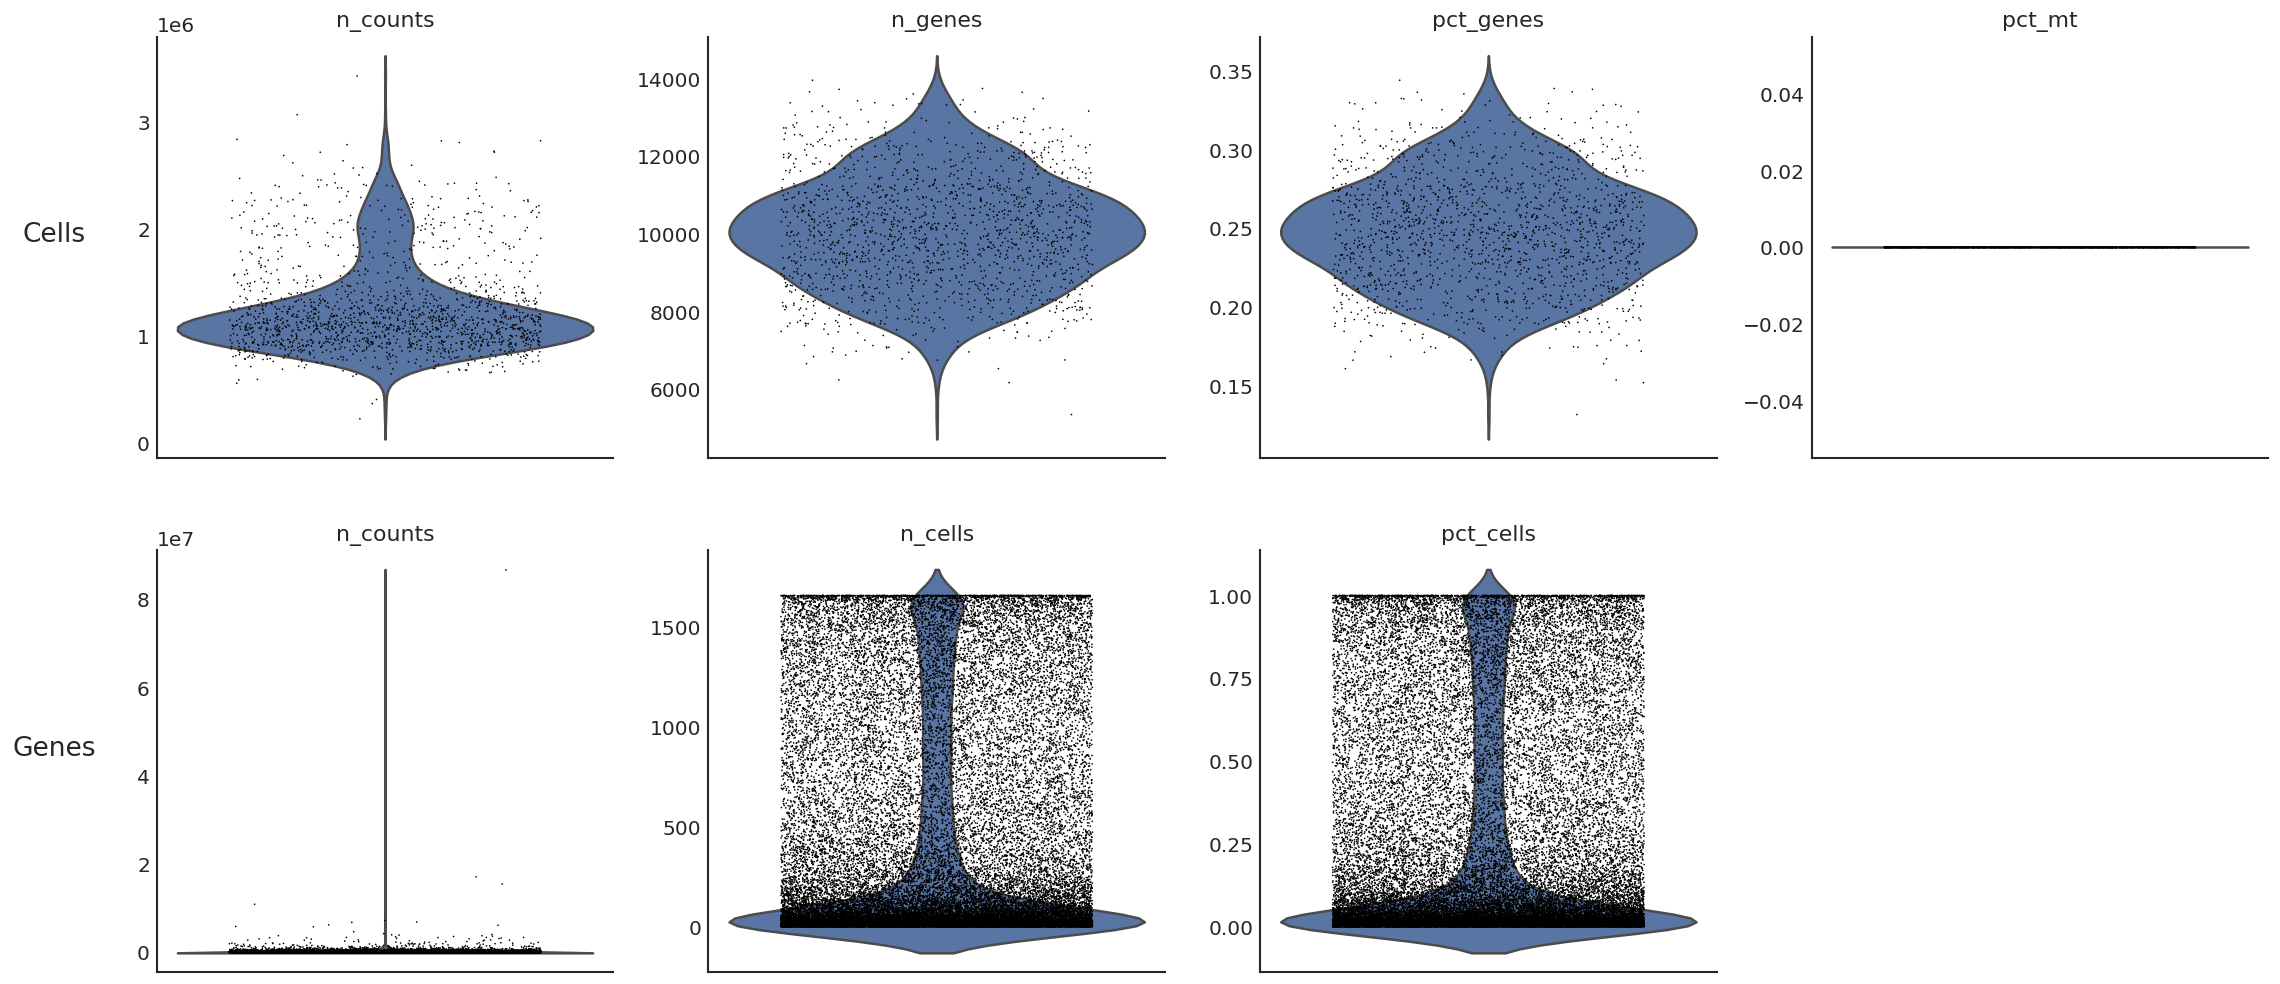

In [12]:
st.plot_qc(adata,jitter=0.3,)

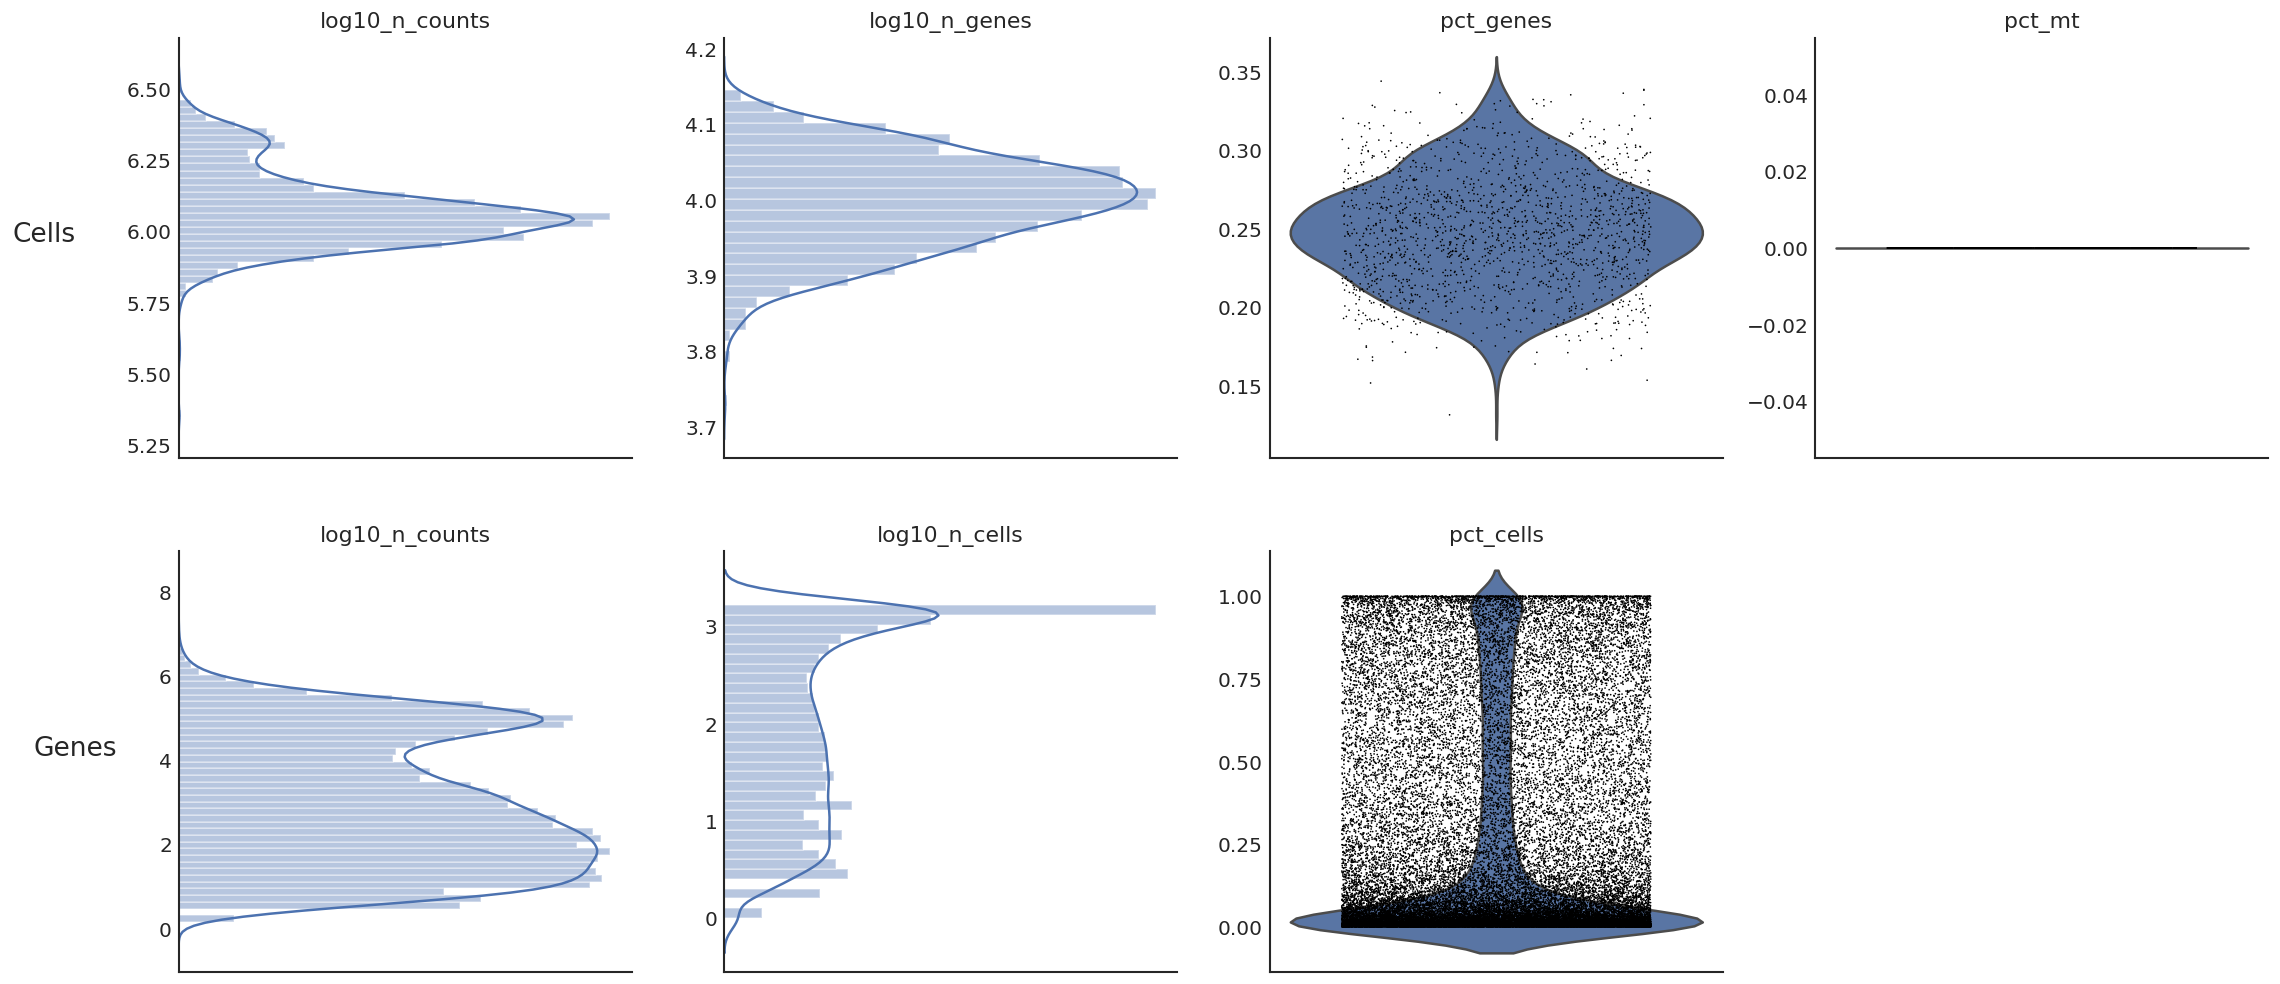

In [13]:
### histogram plots and log-scale are also supported
st.plot_qc(adata,jitter=0.3,log_scale=[0,1,4,5],hist_plot=[0,1,4,5]) 

In [14]:
st.filter_cells(adata, min_n_features= 100)
st.filter_features(adata, min_n_cells = 5)

filter cells based on min_n_features
after filtering out low-quality cells: 
1656 cells, 40594 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
1656 cells, 35077 genes


In [15]:
###Normalize gene expression based on library size  
st.normalize(adata,method='lib_size')
###Logarithmize gene expression 
st.log_transform(adata)
###Remove mitochondrial genes 
st.remove_mt_genes(adata)

#### Feature selection

Please check if the blue curve fits the points well. If not, please adjust the parameter **'loess_frac'** (usually by lowering it) until the blue curve fits well. 

1754 variable genes are selected
CPU times: user 7.18 s, sys: 555 ms, total: 7.74 s
Wall time: 36.7 s


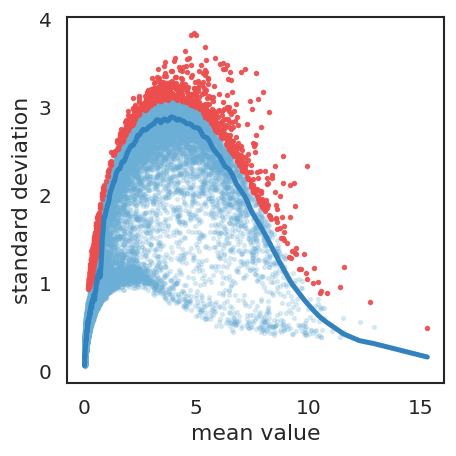

In [16]:
%%time
st.select_variable_genes(adata,loess_frac=0.01,percentile=95)

In [17]:
adata

AnnData object with n_obs × n_vars = 1656 × 35077 
    obs: 'n_counts', 'n_genes', 'pct_genes', 'pct_mt'
    var: 'n_counts', 'n_cells', 'pct_cells'
    uns: 'workdir', 'assay', 'var_genes'
    obsm: 'var_genes'

#### Save most variable genes to a new dataframe

In [18]:
# extract the genes index
var_genes = adata.uns["var_genes"]
var_genes

Index(['8430408G22Rik', 'Plp1', 'Zfp947', 'Bhlhb9', 'Vps35', 'Fam107b',
       'Atp1b2', 'Gm14230', 'Plekhn1', 'Ankrd6',
       ...
       'Nectin2', 'Zfp114', 'Tyrobp', 'Plekhf1', 'Nkg7', 'Osbpl1a', 'Slc27a6',
       'Gm4951', 'Rab18', 'Rnf125'],
      dtype='object', length=1754)

In [19]:
list(_publish_dir.glob("*csv"))

[PosixPath('/data/data_filtered_vargenes/GSE122466_Retina.csv'),
 PosixPath('/data/data_filtered_vargenes/GSE156234_Macrophages.csv')]

In [20]:
adata.to_df()[var_genes].to_csv(outfile.as_posix())

In [21]:
list(_publish_dir.glob("*csv"))

[PosixPath('/data/data_filtered_vargenes/GSE122466_Retina.csv'),
 PosixPath('/data/data_filtered_vargenes/GSE156234_Macrophages.csv'),
 PosixPath('/data/data_filtered_vargenes/GSE81682_Hematopoiesis.csv')]